In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytesseract opencv-python-headless Pillow

In [ ]:

import os
from google.colab import drive
import pytesseract
from PIL import Image
import cv2
import numpy as np
from pathlib import Path

def mount_google_drive():
    """Mount Google Drive to access images."""
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")

def preprocess_image(image):
    """
    Preprocess the image to improve OCR accuracy.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to preprocess the image
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Apply dilation to connect text components
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    gray = cv2.dilate(gray, kernel, iterations=1)

    # Apply median blur to remove noise
    gray = cv2.medianBlur(gray, 3)

    return gray

def detect_text(image_path):
    """
    Detect and extract text from an image using Tesseract OCR.
    """
    try:
        # Read the image using OpenCV
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Perform OCR on the processed image
        text = pytesseract.image_to_string(processed_image)

        # Get bounding boxes for text regions
        boxes = pytesseract.image_to_boxes(processed_image)

        # Draw boxes around detected text
        height, width = processed_image.shape
        for b in boxes.splitlines():
            b = b.split()
            if len(b) == 6:
                x1, y1, x2, y2 = int(b[1]), height - int(b[2]), int(b[3]), height - int(b[4])
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        return text.strip(), image

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None

def main():
    # Install tesseract if not already installed
    !apt-get install tesseract-ocr -y

    # Mount Google Drive
    mount_google_drive()

    # Specify the folder path
    folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images')

    # Create output directory for annotated images
    output_dir = folder_path / 'output'
    output_dir.mkdir(exist_ok=True)

    # Process all images in the folder
    supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')

    for image_path in folder_path.glob('*'):
        if image_path.suffix.lower() in supported_formats:
            print(f"\nProcessing: {image_path.name}")

            # Detect text and get annotated image
            detected_text, annotated_image = detect_text(image_path)

            if detected_text and annotated_image is not None:
                # Save the annotated image
                output_path = output_dir / f'annotated_{image_path.name}'
                cv2.imwrite(str(output_path), annotated_image)

                # Save detected text to a text file
                text_output_path = output_dir / f'{image_path.stem}_text.txt'
                with open(text_output_path, 'w', encoding='utf-8') as f:
                    f.write(detected_text)

                print(f"Detected Text:\n{detected_text}\n")
                print(f"Annotated image saved to: {output_path}")
                print(f"Text saved to: {text_output_path}")
            else:
                print(f"Failed to process {image_path.name}")

if __name__ == "__main__":
    main()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (11.8 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [ ]:
!pip install tqdm

In [ ]:
import os
from google.colab import drive
import pytesseract
from PIL import Image
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def verify_tesseract():
    """Verify Tesseract installation and version."""
    try:
        version = pytesseract.get_tesseract_version()
        logger.info(f"Tesseract version: {version}")
        return True
    except Exception as e:
        logger.error(f"Tesseract not properly installed: {str(e)}")
        return False

def preprocess_image(image):
    """
    Enhanced preprocessing pipeline for better OCR results.
    """
    try:
        # Convert to grayscale if image is in color
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

        # Denoise the image
        denoised = cv2.fastNlMeansDenoising(thresh)

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)

        return enhanced
    except Exception as e:
        logger.error(f"Error in preprocessing: {str(e)}")
        return image

def detect_text(image_path, lang='eng'):
    """
    Enhanced text detection with confidence scores and multiple language support.
    """
    try:
        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Store original image dimensions
        orig_h, orig_w = image.shape[:2]

        # Resize if image is too large (helps with OCR accuracy)
        max_dimension = 2000
        if max(orig_h, orig_w) > max_dimension:
            scale = max_dimension / max(orig_h, orig_w)
            image = cv2.resize(image, None, fx=scale, fy=scale)

        # Preprocess
        processed = preprocess_image(image)

        # Perform OCR with confidence
        data = pytesseract.image_to_data(processed, lang=lang, output_type=pytesseract.Output.DICT)

        # Draw boxes and collect text with confidence
        detected_text = []
        for i, conf in enumerate(data['conf']):
            if conf > 0:  # Filter out low confidence detections
                text = data['text'][i]
                if text.strip():  # Only process non-empty text
                    x, y, w, h = (data['left'][i], data['top'][i],
                                data['width'][i], data['height'][i])
                    # Draw rectangle
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    # Add text with confidence
                    detected_text.append(f"{text} (Confidence: {conf:.1f}%)")

        return '\n'.join(detected_text), image

    except Exception as e:
        logger.error(f"Error processing {image_path}: {str(e)}")
        return None, None

def process_folder():
    """
    Process all images in the specified folder with progress tracking.
    """
    folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
    output_dir = folder_path / 'output'
    output_dir.mkdir(exist_ok=True)

    # Supported image formats
    supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')

    # Get list of image files
    image_files = [f for f in folder_path.glob('*') if f.suffix.lower() in supported_formats]

    if not image_files:
        logger.warning(f"No supported image files found in {folder_path}")
        return

    logger.info(f"Found {len(image_files)} images to process")

    # Process each image with progress bar
    for image_path in tqdm(image_files, desc="Processing images"):
        logger.info(f"Processing: {image_path.name}")

        detected_text, annotated_image = detect_text(image_path)

        if detected_text and annotated_image is not None:
            # Save annotated image
            output_path = output_dir / f'annotated_{image_path.name}'
            cv2.imwrite(str(output_path), annotated_image)

            # Save detected text
            text_output_path = output_dir / f'{image_path.stem}_text.txt'
            with open(text_output_path, 'w', encoding='utf-8') as f:
                f.write(detected_text)

            logger.info(f"Successfully processed {image_path.name}")
        else:
            logger.error(f"Failed to process {image_path.name}")

def main():
    """
    Main execution function with enhanced error handling.
    """
    try:
        logger.info("Starting OCR processing...")

        # Verify Tesseract installation
        if not verify_tesseract():
            logger.error("Tesseract verification failed. Please check installation.")
            return

        # Process images
        process_folder()

        logger.info("OCR processing completed successfully!")

    except Exception as e:
        logger.error(f"An error occurred during execution: {str(e)}")

if __name__ == "__main__":
    main()

Processing images: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


In [ ]:
!pip install matplotlib

In [ ]:
import os
from google.colab import drive
import pytesseract
from PIL import Image
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def preprocess_image(image):
    """
    Preprocess the image to improve OCR accuracy.
    """
    # Convert to grayscale if image is in color
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Denoise
    denoised = cv2.fastNlMeansDenoising(thresh)

    return denoised

def detect_and_display(image_path):
    """
    Detect text in image and display results in console.
    """
    try:
        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Convert BGR to RGB for matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocess
        processed = preprocess_image(image)

        # Perform OCR
        data = pytesseract.image_to_data(processed, output_type=pytesseract.Output.DICT)

        # Draw boxes and collect text
        result_image = image_rgb.copy()
        detected_text = []

        for i, conf in enumerate(data['conf']):
            if conf > 0:  # Filter out low confidence detections
                text = data['text'][i]
                if text.strip():  # Only process non-empty text
                    x, y, w, h = (data['left'][i], data['top'][i],
                                data['width'][i], data['height'][i])
                    # Draw rectangle
                    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    detected_text.append(f"{text} ({conf:.1f}%)")

        # Display image with detected text regions
        plt.figure(figsize=(15, 10))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Detected Text Regions in: {Path(image_path).name}")
        plt.show()

        # Display detected text
        print("\nDetected Text:")
        print("-" * 50)
        for text in detected_text:
            print(text)
        print("-" * 50)
        print()

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Specify the folder path
    folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')

    # Process all images in the folder
    supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')

    # Get list of image files
    image_files = [f for f in folder_path.glob('*') if f.suffix.lower() in supported_formats]

    if not image_files:
        print(f"No supported image files found in {folder_path}")
        return

    print(f"Found {len(image_files)} images to process\n")

    # Process each image
    for image_path in image_files:
        print(f"Processing: {image_path.name}")
        detect_and_display(image_path)

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install easyocr torch torchvision
!pip install opencv-python-headless
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 19.3 MB/s eta 0:00:00


In [ ]:
# # First, uninstall existing packages that might cause conflicts
# !pip uninstall -y torch torchvision easyocr sympy

# Install required packages in the correct order
!pip install sympy==1.12
!pip install torch torchvision
!pip install easyocr

  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-many

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing EasyOCR reader for English and Bangla (this may take a moment)...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Found 20 images to process


Processing image 1/20: 1724325762952.jpg
Detecting text in English and Bangla... (this may take a few moments)


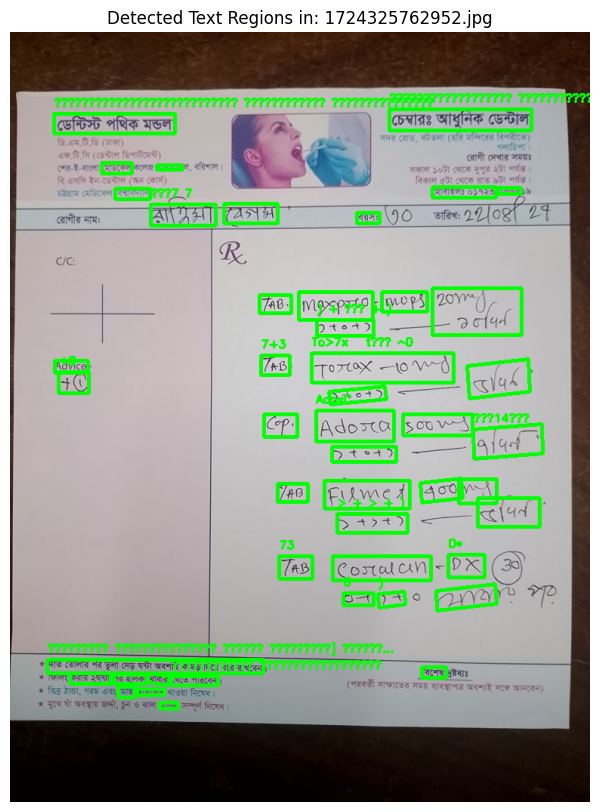


Detected Text:
----------------------------------------------------------------------
1. [Bangla] ডেন্টিস্ট পথিক মঙুডল (32.5%)
2. [Bangla] চেমারঃ আধুনিক ডেন্টাল (43.2%)
3. [Bangla] য7 7 (61.8%)
4. [Bangla] ) + ০ + ) (32.5%)
5. [English] 7+3 (96.1%)
6. [Bangla] To>7x   t০ ^0 (42.3%)
7. [English] +0 (53.1%)
8. [English] AdoxC (32.3%)
9. [English] > + > + ) (51.8%)
10. [English] 73 (99.1%)
11. [English] D* (37.6%)
12. [English] 0 (41.5%)
13. [Bangla] দাত তোলার পর তূল] দেড় ঘন্টা অবশাই শামড দিয়ে ধরে বাববেন (38.3%)
14. [Bangla] বেতে পানবেন (56.1%)
15. [Bangla] ৭14ণ (60.2%)
16. [English] ) (98.8%)
----------------------------------------------------------------------


Processing image 2/20: 1724307128717.jpg
Detecting text in English and Bangla... (this may take a few moments)


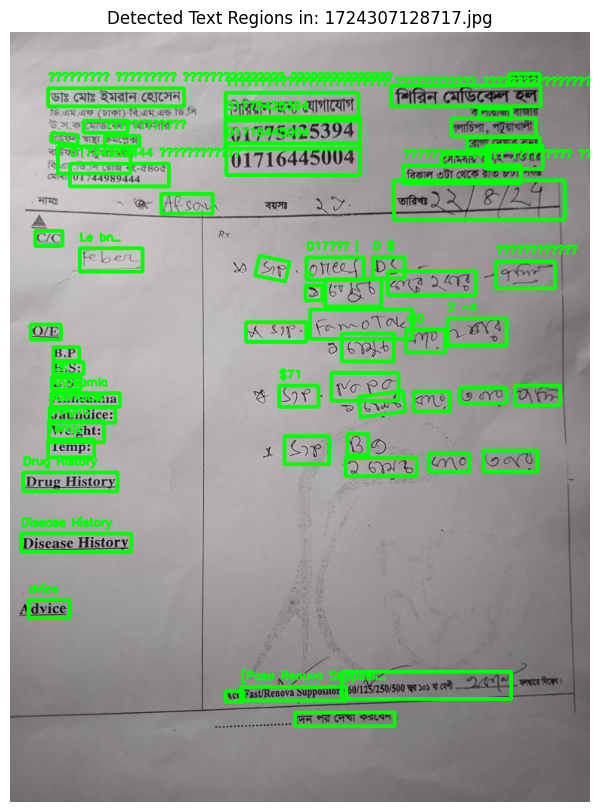


Detected Text:
----------------------------------------------------------------------
1. [Bangla] ডাঃ মোঃ হমরান হোসেন (49.3%)
2. [Bangla] সিরিয়াল জন্য যোগাযোগ (69.4%)
3. [English] 01775425394 (99.8%)
4. [Bangla] কশাে (41.5%)
5. [English] 01716445004 (68.7%)
6. [Bangla] 01744989444 ৫৪০৫ (80.4%)
7. [Bangla] বিকাল ৩টা থেকে বাত ৮টা (43.4%)
8. [English] Le bn_ (44.6%)
9. [Bangla] 017৫ | (65.1%)
10. [English] D $ (69.8%)
11. [Bangla] পপ্ি (50.7%)
12. [English] > (57.0%)
13. [English] 2 ^4 (45.7%)
14. [English] 4|0 (32.7%)
15. [English] Ls: (63.4%)
16. [English] Anneamla (57.3%)
17. [English] $71 (62.1%)
18. [English] Jaundice: (73.2%)
19. [English] Weight: (95.8%)
20. [English] Temp: (96.1%)
21. [English] Drug History (97.5%)
22. [English] Disease History (100.0%)
23. [English] dvice (80.6%)
24. [English] [Pasu Renuva Suppusitury (43.0%)
----------------------------------------------------------------------


Processing image 3/20: 1724308027957.jpg
Detecting text in English and Bangla... 

KeyboardInterrupt: 

In [ ]:
# # First, uninstall existing packages that might cause conflicts
# !pip uninstall -y torch torchvision easyocr sympy

# # Install required packages in the correct order
# !pip install sympy==1.12
# !pip install torch torchvision
# !pip install easyocr

# Now import the required libraries
import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import easyocr

def initialize_reader():
    """
    Initialize EasyOCR reader with English and Bangla languages.
    """
    print("Initializing EasyOCR reader for English and Bangla (this may take a moment)...")
    # 'en' for English, 'bn' for Bangla/Bengali
    return easyocr.Reader(['en', 'bn'], gpu=torch.cuda.is_available())

def enhance_image(image):
    """
    Enhance image quality for better OCR results
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Bilateral filter for better edge preservation
    bilateral = cv2.bilateralFilter(enhanced, 9, 75, 75)

    return bilateral

def detect_and_display(reader, image_path):
    """
    Detect text in image and display results in console
    """
    try:
        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Convert BGR to RGB for matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Enhance image
        enhanced_img = enhance_image(image)

        print("Detecting text in English and Bangla... (this may take a few moments)")
        # Detect text
        results = reader.readtext(enhanced_img)

        # Draw boxes and collect text
        result_image = image_rgb.copy()
        detected_text = []

        for (bbox, text, prob) in results:
            # Convert bbox points to integers
            bbox = np.array(bbox).astype(int)

            # Draw rectangle with thicker lines
            cv2.polylines(result_image, [bbox], True, (0, 255, 0), 3)

            # Add text and confidence to list
            confidence = prob * 100
            if confidence > 30:  # Filter out very low confidence detections
                # Determine if text is Bangla
                is_bangla = any(ord(c) >= 0x0980 and ord(c) <= 0x09FF for c in text)
                lang_type = "Bangla" if is_bangla else "English"

                detected_text.append({
                    'text': text,
                    'confidence': confidence,
                    'language': lang_type
                })

                # Add text label above the box
                x = bbox[0][0]
                y = bbox[0][1] - 10
                label = f"{text[:20]}..." if len(text) > 20 else text
                cv2.putText(result_image, label, (x, y),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display image with detected text regions
        plt.figure(figsize=(15, 10))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Detected Text Regions in: {Path(image_path).name}")
        plt.show()

        # Display detected text
        if detected_text:
            print("\nDetected Text:")
            print("-" * 70)
            for i, item in enumerate(detected_text, 1):
                print(f"{i}. [{item['language']}] {item['text']} ({item['confidence']:.1f}%)")
            print("-" * 70)
            print()
        else:
            print("\nNo text detected in this image\n")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize EasyOCR reader
        reader = initialize_reader()

        # Specify the folder path
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')

        # Process all images in the folder
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')

        # Get list of image files
        image_files = [f for f in folder_path.glob('*') if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        # Process each image
        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(reader, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
# Install PaddlePaddle and PaddleOCR
!pip install paddlepaddle
!pip install "paddleocr>=2.0.6"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a670a26ad0be9eabfcd74cd32ba6e4aef3ff6ff7b69142b4c75330801a7bf4af
  Sto

In [ ]:


import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize PaddleOCR with optimized settings
    """
    print("Initializing PaddleOCR (this will be quick)...")
    return PaddleOCR(
        use_angle_cls=True,  # Detect rotated text
        lang='en',  # English
        use_gpu=True,  # Use GPU if available
        show_log=False,  # Disable logs for speed
        det_db_box_thresh=0.3,  # Lower threshold for better detection
        det_limit_side_len=960,  # Limit image size for faster processing
        use_mp=True  # Use multiprocessing
    )

def preprocess_image(image):
    """
    Fast and effective image preprocessing
    """
    # Resize image if too large (maintains aspect ratio)
    max_dimension = 1500
    height, width = image.shape[:2]
    if max(height, width) > max_dimension:
        scale = max_dimension / max(height, width)
        image = cv2.resize(image, None, fx=scale, fy=scale)

    # Fast contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge((l,a,b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return enhanced

def detect_and_display(ocr, image_path):
    """
    Fast text detection and display
    """
    try:
        start_time = time.time()

        # Read and preprocess image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Preprocess
        processed_image = preprocess_image(image)

        # OCR detection
        result = ocr.ocr(processed_image, cls=True)

        if not result[0]:
            print("No text detected in the image")
            return

        # Prepare visualization
        image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        boxes = [detection[0] for detection in result[0]]
        texts = [detection[1][0] for detection in result[0]]
        scores = [detection[1][1] for detection in result[0]]

        # Draw results
        plt.figure(figsize=(15, 10))
        plt.imshow(image_rgb)

        for box, text, score in zip(boxes, texts, scores):
            # Convert box points to integers
            box = np.array(box).astype(int)

            # Draw polygon around text
            pts = box.reshape((-1, 1, 2))
            cv2.polylines(image_rgb, [pts], True, (0, 255, 0), 2)

            # Add text label
            x, y = box[0]
            plt.text(x, y-10, f'{text[:20]}...', color='green',
                    bbox=dict(facecolor='white', alpha=0.7))

        plt.axis('off')
        plt.title(f"Detected Text in: {Path(image_path).name}")
        plt.show()

        # Print detected text
        print("\nDetected Text:")
        print("-" * 50)
        for i, (text, score) in enumerate(zip(texts, scores), 1):
            confidence = float(score) * 100
            if confidence > 50:  # Filter low confidence detections
                print(f"{i}. {text} ({confidence:.1f}%)")
        print("-" * 50)

        # Print processing time
        processing_time = time.time() - start_time
        print(f"\nProcessing time: {processing_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR
        ocr = initialize_ocr()

        # Specify the folder path
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')

        # Supported formats
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')

        # Get image files
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        # Process each image
        total_start_time = time.time()

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(ocr, image_path)

        total_time = time.time() - total_start_time
        print(f"\nTotal processing time for all images: {total_time:.2f} seconds")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing PaddleOCR (this will be quick)...

Found 20 images to process


Processing image 1/20: 1724325762952.jpg


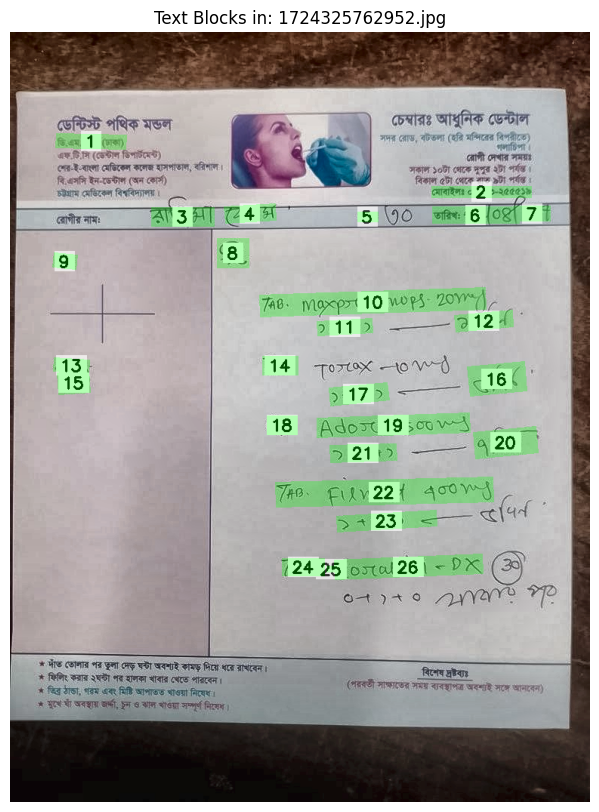


Detected Text Blocks:

Block 1:
--------------------
Text: ..
Confidence: 82.5%

Block 2:
--------------------
Text: 0390-000
Confidence: 78.1%

Block 3:
--------------------
Text: AAHI
Confidence: 63.7%

Block 4:
--------------------
Text: 4551
Confidence: 65.3%

Block 5:
--------------------
Text: 4
Confidence: 61.3%

Block 6:
--------------------
Text: 208
Confidence: 90.9%

Block 7:
--------------------
Text: 24
Confidence: 52.5%

Block 8:
--------------------
Text: R
Confidence: 97.5%

Block 9:
--------------------
Text: C/C:
Confidence: 78.0%

Block 10:
--------------------
Text: 7ABmaxpo=mps-20
Confidence: 72.7%

Block 11:
--------------------
Text: >+0+)
Confidence: 60.0%

Block 12:
--------------------
Text: Fhloe
Confidence: 77.2%

Block 13:
--------------------
Text: Advice
Confidence: 99.8%

Block 14:
--------------------
Text: TAB
Confidence: 89.4%

Block 15:
--------------------
Text: +
Confidence: 51.1%

Block 16:
--------------------
Text: yb1D
Confidence: 65.1%

Block

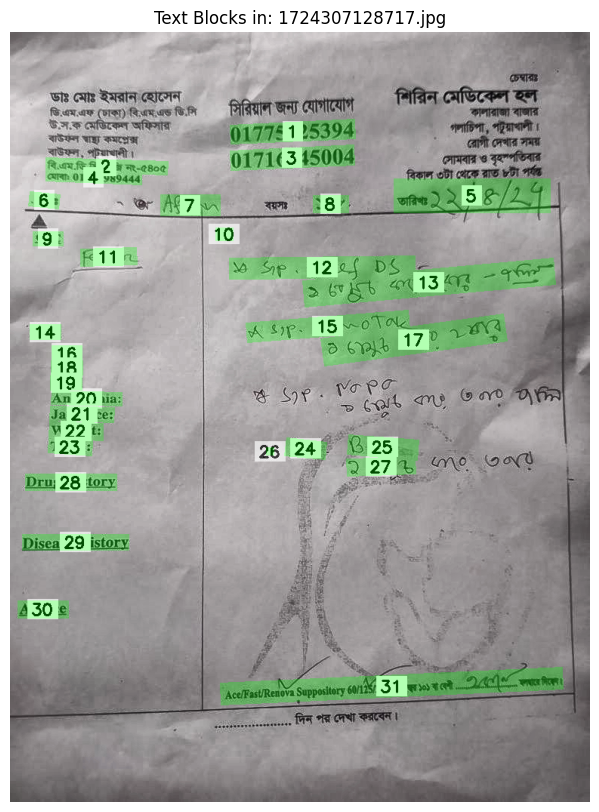


Detected Text Blocks:

Block 1:
--------------------
Text: 01775425394
Confidence: 99.8%

Block 2:
--------------------
Text: 8
Confidence: 83.5%

Block 3:
--------------------
Text: 01716445004
Confidence: 99.7%

Block 4:
--------------------
Text: 01744989444
Confidence: 94.2%

Block 5:
--------------------
Text: /824
Confidence: 77.9%

Block 6:
--------------------
Text: Stlle"
Confidence: 50.1%

Block 7:
--------------------
Text: ARsOn
Confidence: 63.7%

Block 8:
--------------------
Text: LC
Confidence: 56.6%

Block 9:
--------------------
Text: C/C
Confidence: 96.7%

Block 10:
--------------------
Text: Rx
Confidence: 93.2%

Block 11:
--------------------
Text: feber
Confidence: 79.3%

Block 12:
--------------------
Text: SpOneeDS
Confidence: 63.7%

Block 13:
--------------------
Text: 6-9
Confidence: 50.1%

Block 14:
--------------------
Text: O/E
Confidence: 97.4%

Block 15:
--------------------
Text: srFomoTol
Confidence: 56.5%

Block 16:
--------------------
Text: B.P
Confi

KeyboardInterrupt: 

In [ ]:
# Install PaddlePaddle and PaddleOCR
# !pip install paddlepaddle
# !pip install "paddleocr>=2.0.6"

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize PaddleOCR with optimized settings
    """
    print("Initializing PaddleOCR (this will be quick)...")
    return PaddleOCR(
        use_angle_cls=True,
        lang='en',
        use_gpu=True,
        show_log=False,
        det_db_box_thresh=0.3,
        det_limit_side_len=960,
        use_mp=True
    )

def preprocess_image(image):
    """
    Fast and effective image preprocessing
    """
    max_dimension = 1500
    height, width = image.shape[:2]
    if max(height, width) > max_dimension:
        scale = max_dimension / max(height, width)
        image = cv2.resize(image, None, fx=scale, fy=scale)

    # Enhance contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge((l,a,b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return enhanced

def display_block_numbers(image_rgb, boxes):
    """
    Display image with numbered blocks
    """
    result_image = image_rgb.copy()
    height, width = result_image.shape[:2]

    # Create a semi-transparent overlay for better number visibility
    overlay = result_image.copy()

    for idx, box in enumerate(boxes, 1):
        # Convert box points to integers
        box = np.array(box).astype(int)

        # Draw filled polygon with transparency
        cv2.fillPoly(overlay, [box], (0, 255, 0))

        # Calculate center point of the box for block number
        center_x = int(np.mean(box[:, 0]))
        center_y = int(np.mean(box[:, 1]))

        # Draw block number with background
        text = str(idx)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        thickness = 2

        # Draw white background for number
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
        cv2.rectangle(result_image,
                     (center_x - text_width//2 - 5, center_y - text_height//2 - 5),
                     (center_x + text_width//2 + 5, center_y + text_height//2 + 5),
                     (255, 255, 255), -1)

        # Draw number
        cv2.putText(result_image, text,
                    (center_x - text_width//2, center_y + text_height//2),
                    font, font_scale, (0, 0, 0), thickness)

    # Combine original image with overlay
    result_image = cv2.addWeighted(overlay, 0.3, result_image, 0.7, 0)

    return result_image

def detect_and_display(ocr, image_path):
    """
    Detect text and display results with clean output
    """
    try:
        start_time = time.time()

        # Read and preprocess image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Preprocess
        processed_image = preprocess_image(image)

        # OCR detection
        result = ocr.ocr(processed_image, cls=True)

        if not result[0]:
            print("No text detected in the image")
            return

        # Convert BGR to RGB for display
        image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

        # Extract detection results
        boxes = [detection[0] for detection in result[0]]
        texts = [detection[1][0] for detection in result[0]]
        scores = [detection[1][1] for detection in result[0]]

        # Display image with numbered blocks
        result_image = display_block_numbers(image_rgb, boxes)

        # Show image
        plt.figure(figsize=(15, 10))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Text Blocks in: {Path(image_path).name}")
        plt.show()

        # Print detected text with block numbers
        print("\nDetected Text Blocks:")
        print("=" * 50)
        for idx, (text, score) in enumerate(zip(texts, scores), 1):
            confidence = float(score) * 100
            if confidence > 50:  # Filter low confidence detections
                print(f"\nBlock {idx}:")
                print("-" * 20)
                print(f"Text: {text}")
                print(f"Confidence: {confidence:.1f}%")
        print("=" * 50)

        # Print processing time
        processing_time = time.time() - start_time
        print(f"\nProcessing time: {processing_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR
        ocr = initialize_ocr()

        # Specify the folder path
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')

        # Get image files
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        # Process each image
        total_start_time = time.time()

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(ocr, image_path)

        total_time = time.time() - total_start_time
        print(f"\nTotal processing time for all images: {total_time:.2f} seconds")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:

# Install PaddlePaddle and PaddleOCR
# !pip install paddlepaddle
# !pip install "paddleocr>=2.0.6"

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize PaddleOCR with fixed settings
    """
    print("Initializing PaddleOCR...")
    return PaddleOCR(
        use_angle_cls=True,
        lang='en',
        use_gpu=True,
        show_log=False,
        # Optimized settings for detailed text detection
        det_db_thresh=0.2,
        det_db_box_thresh=0.2,
        det_db_unclip_ratio=1.8,
        use_mp=True
    )

def extract_top_portion(image, portion=1/3):
    """
    Extract and enhance the top portion of the image
    """
    height = image.shape[0]
    top_height = int(height * portion)
    top_portion = image[:top_height, :]

    return top_portion

def enhance_image_quality(image):
    """
    Enhanced preprocessing specifically for top portion
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)

    # Merge channels back
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Sharpen
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)

    return sharpened

def preprocess_image(image):
    """
    Preprocessing pipeline for top portion
    """
    # Extract top third
    top_portion = extract_top_portion(image)

    # Resize if width is too large
    max_width = 2000
    if top_portion.shape[1] > max_width:
        ratio = max_width / top_portion.shape[1]
        new_height = int(top_portion.shape[0] * ratio)
        top_portion = cv2.resize(top_portion, (max_width, new_height))

    # Enhance image quality
    enhanced = enhance_image_quality(top_portion)

    return enhanced, top_portion.shape[:2]

def display_results(image, boxes, texts, scores, original_shape):
    """
    Display results with numbered blocks
    """
    result_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = result_image.copy()

    # Draw detected regions
    valid_detections = []
    for idx, (box, text, score) in enumerate(zip(boxes, texts, scores), 1):
        confidence = float(score)
        if confidence > 0.5:  # Filter by confidence
            box = np.array(box).astype(int)

            # Draw filled polygon with transparency
            cv2.fillPoly(overlay, [box], (0, 255, 0))

            # Calculate center point
            center_x = int(np.mean(box[:, 0]))
            center_y = int(np.mean(box[:, 1]))

            # Draw block number
            cv2.putText(result_image, str(idx),
                       (center_x, center_y),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.7, (0, 0, 0), 2)

            valid_detections.append((idx, text, confidence))

    # Combine images
    result_image = cv2.addWeighted(overlay, 0.3, result_image, 0.7, 0)

    # Display
    plt.figure(figsize=(15, 5))
    plt.imshow(result_image)
    plt.axis('off')
    plt.title(f"Top One-Third Portion (Height: {original_shape[0]}px)")
    plt.show()

    return valid_detections

def detect_and_display(ocr, image_path):
    """
    Detect text in top portion and display results
    """
    try:
        start_time = time.time()

        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Preprocess top portion
        processed_image, original_shape = preprocess_image(image)

        # OCR detection
        result = ocr.ocr(processed_image, cls=True)

        if not result[0]:
            print("No text detected in the top portion")
            return

        # Extract results
        boxes = [detection[0] for detection in result[0]]
        texts = [detection[1][0] for detection in result[0]]
        scores = [detection[1][1] for detection in result[0]]

        # Display results and get valid detections
        valid_detections = display_results(processed_image, boxes, texts, scores, original_shape)

        # Print detected text
        if valid_detections:
            print("\nDetected Text in Top One-Third Portion:")
            print("=" * 60)

            # Sort by confidence
            valid_detections.sort(key=lambda x: x[2], reverse=True)

            for block_num, text, confidence in valid_detections:
                print(f"\nBlock {block_num}:")
                print("-" * 20)
                print(f"Text: {text}")
                print(f"Confidence: {confidence * 100:.1f}%")

            print("=" * 60)
        else:
            print("\nNo high-confidence text detected")

        print(f"\nProcessing time: {time.time() - start_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR
        ocr = initialize_ocr()

        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(ocr, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Install PaddlePaddle and PaddleOCR
# !pip install paddlepaddle
# !pip install "paddleocr>=2.0.6"

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize PaddleOCR with both English and Bengali support
    """
    print("Initializing PaddleOCR for English and Bengali...")
    return PaddleOCR(
        use_angle_cls=True,
        lang='en',  # Base language
        use_gpu=True,
        show_log=False,
        # More sensitive detection settings
        det_db_thresh=0.1,  # Lower threshold to detect more text
        det_db_box_thresh=0.1,  # Lower box threshold
        det_db_unclip_ratio=2.0,  # Larger ratio to catch more text
        det_limit_side_len=2560,  # Larger size limit
        use_mp=True,
        # Additional recognition model for Bengali
        rec_algorithm='SVTR_LCNet',  # Better recognition model
        enable_mkldnn=True  # Speed up CPU inference
    )

def enhance_image_quality(image):
    """
    Enhanced preprocessing for better text detection
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply multiple CLAHE passes
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)
    enhanced_l = clahe.apply(enhanced_l)  # Second pass

    # Merge channels
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Apply additional enhancements
    # Increase contrast
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.2, beta=0)

    # Sharpen
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    return enhanced

def preprocess_image(image):
    """
    Comprehensive preprocessing pipeline
    """
    # Get dimensions
    height, width = image.shape[:2]

    # Extract top third with a slight margin
    top_height = int(height * 0.35)  # Increased from 1/3 to catch slightly more
    top_portion = image[:top_height, :]

    # Resize if needed while maintaining aspect ratio
    max_width = 2560
    if width > max_width:
        ratio = max_width / width
        new_height = int(top_height * ratio)
        top_portion = cv2.resize(top_portion, (max_width, new_height))

    # Apply quality enhancement
    enhanced = enhance_image_quality(top_portion)

    # Create multiple versions with different preprocessing
    versions = []

    # Version 1: Enhanced original
    versions.append(enhanced)

    # Version 2: Higher contrast
    contrast_enhanced = cv2.convertScaleAbs(enhanced, alpha=1.4, beta=0)
    versions.append(contrast_enhanced)

    # Version 3: Sharpened
    sharpened = cv2.filter2D(enhanced, -1,
                            np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]))
    versions.append(sharpened)

    return versions, top_portion.shape[:2]

def merge_nearby_detections(boxes, texts, scores, threshold=30):
    """
    Merge text detections that are very close to each other
    """
    merged_boxes = []
    merged_texts = []
    merged_scores = []
    used = set()

    for i in range(len(boxes)):
        if i in used:
            continue

        current_box = np.array(boxes[i])
        current_text = texts[i]
        current_score = scores[i]

        # Find nearby boxes
        for j in range(i + 1, len(boxes)):
            if j in used:
                continue

            next_box = np.array(boxes[j])

            # Calculate distance between boxes
            dist = np.min(np.linalg.norm(current_box[:, None] - next_box, axis=2))

            if dist < threshold:
                # Merge boxes
                current_box = np.vstack((current_box, next_box))
                current_text = f"{current_text} {texts[j]}"
                current_score = max(current_score, scores[j])
                used.add(j)

        merged_boxes.append(current_box)
        merged_texts.append(current_text)
        merged_scores.append(current_score)

    return merged_boxes, merged_texts, merged_scores

def detect_and_display(ocr, image_path):
    """
    Enhanced text detection and display
    """
    try:
        start_time = time.time()

        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Get preprocessed versions
        image_versions, original_shape = preprocess_image(image)

        # Detect text in all versions
        all_boxes = []
        all_texts = []
        all_scores = []

        for img_version in image_versions:
            result = ocr.ocr(img_version, cls=True)
            if result[0]:
                boxes = [detection[0] for detection in result[0]]
                texts = [detection[1][0] for detection in result[0]]
                scores = [detection[1][1] for detection in result[0]]

                # Merge with existing detections
                all_boxes.extend(boxes)
                all_texts.extend(texts)
                all_scores.extend(scores)

        if not all_boxes:
            print("No text detected in the top portion")
            return

        # Merge nearby detections
        boxes, texts, scores = merge_nearby_detections(all_boxes, all_texts, all_scores)

        # Display results
        result_image = cv2.cvtColor(image_versions[0], cv2.COLOR_BGR2RGB)
        overlay = result_image.copy()

        # Draw detected regions
        valid_detections = []
        for idx, (box, text, score) in enumerate(zip(boxes, texts, scores), 1):
            if float(score) > 0.3:  # Lower confidence threshold
                box = np.array(box).astype(int)

                # Draw filled polygon
                cv2.fillPoly(overlay, [box], (0, 255, 0))

                # Calculate center point
                center_x = int(np.mean(box[:, 0]))
                center_y = int(np.mean(box[:, 1]))

                # Draw block number
                cv2.putText(result_image, str(idx),
                           (center_x, center_y),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.7, (0, 0, 0), 2)

                valid_detections.append((idx, text, score))

        # Combine images
        result_image = cv2.addWeighted(overlay, 0.3, result_image, 0.7, 0)

        # Display
        plt.figure(figsize=(15, 5))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Top Portion Text Detection: {Path(image_path).name}")
        plt.show()

        # Print detected text
        if valid_detections:
            print("\nDetected Text:")
            print("=" * 60)

            for block_num, text, confidence in valid_detections:
                print(f"\nBlock {block_num}:")
                print("-" * 20)
                print(f"Text: {text}")
                print(f"Confidence: {confidence * 100:.1f}%")

            print("=" * 60)
            print(f"\nTotal text blocks detected: {len(valid_detections)}")

        print(f"Processing time: {time.time() - start_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR
        ocr = initialize_ocr()

        # Second OCR instance for Bengali
        ocr_bengali = PaddleOCR(lang='bengali', use_angle_cls=True, use_gpu=True)

        # Process images
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(ocr, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing PaddleOCR for English and Bengali...
An error occurred: param lang must in dict_keys(['ch', 'en', 'korean', 'japan', 'chinese_cht', 'ta', 'te', 'ka', 'latin', 'arabic', 'cyrillic', 'devanagari']), but got bengali


In [ ]:
# # Install PaddlePaddle and PaddleOCR
# !pip install paddlepaddle
# !pip install "paddleocr>=2.0.6"

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize PaddleOCR with both English and Devanagari support
    """
    print("Initializing PaddleOCR with multilingual support...")
    # Initialize two OCR instances for better detection
    ocr_english = PaddleOCR(
        use_angle_cls=True,
        lang='en',
        use_gpu=True,
        show_log=False,
        det_db_thresh=0.1,
        det_db_box_thresh=0.1,
        det_db_unclip_ratio=2.0,
        det_limit_side_len=2560,
        use_mp=True
    )

    ocr_indic = PaddleOCR(
        use_angle_cls=True,
        lang='devanagari',
        use_gpu=True,
        show_log=False,
        det_db_thresh=0.1,
        det_db_box_thresh=0.1,
        det_db_unclip_ratio=2.0,
        det_limit_side_len=2560,
        use_mp=True
    )

    return ocr_english, ocr_indic

def enhance_image_quality(image):
    """
    Enhanced preprocessing for better text detection
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply multiple CLAHE passes
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)
    enhanced_l = clahe.apply(enhanced_l)

    # Merge channels
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Increase contrast
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.2, beta=10)

    # Sharpen
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    return enhanced

def preprocess_image(image):
    """
    Extract and preprocess top portion
    """
    height, width = image.shape[:2]
    top_height = int(height * 0.35)  # Top 35%
    top_portion = image[:top_height, :]

    # Process image
    enhanced = enhance_image_quality(top_portion)

    return enhanced, top_portion.shape[:2]

def combine_detections(eng_result, indic_result):
    """
    Combine detections from both OCR instances
    """
    all_boxes = []
    all_texts = []
    all_scores = []
    all_langs = []

    # Process English results
    if eng_result[0]:
        for detection in eng_result[0]:
            box, (text, score) = detection
            if score > 0.3:  # Confidence threshold
                all_boxes.append(box)
                all_texts.append(text)
                all_scores.append(score)
                all_langs.append('English')

    # Process Indic results
    if indic_result[0]:
        for detection in indic_result[0]:
            box, (text, score) = detection
            if score > 0.3:  # Confidence threshold
                all_boxes.append(box)
                all_texts.append(text)
                all_scores.append(score)
                all_langs.append('Bengali')

    return all_boxes, all_texts, all_scores, all_langs

def detect_and_display(ocr_english, ocr_indic, image_path):
    """
    Process image with both OCR engines
    """
    try:
        start_time = time.time()

        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Preprocess image
        processed_image, original_shape = preprocess_image(image)

        # Run both OCR engines
        english_result = ocr_english.ocr(processed_image, cls=True)
        indic_result = ocr_indic.ocr(processed_image, cls=True)

        # Combine results
        boxes, texts, scores, langs = combine_detections(english_result, indic_result)

        if not boxes:
            print("No text detected in the top portion")
            return

        # Display results
        result_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        overlay = result_image.copy()

        # Draw detected regions
        valid_detections = []
        for idx, (box, text, score, lang) in enumerate(zip(boxes, texts, scores, langs), 1):
            box = np.array(box).astype(int)

            # Different colors for different languages
            color = (0, 255, 0) if lang == 'English' else (255, 0, 0)

            # Draw filled polygon
            cv2.fillPoly(overlay, [box], color)

            # Calculate center point
            center_x = int(np.mean(box[:, 0]))
            center_y = int(np.mean(box[:, 1]))

            # Draw block number
            cv2.putText(result_image, str(idx),
                       (center_x, center_y),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.7, (0, 0, 0), 2)

            valid_detections.append((idx, text, score, lang))

        # Combine images
        result_image = cv2.addWeighted(overlay, 0.3, result_image, 0.7, 0)

        # Display
        plt.figure(figsize=(15, 5))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Text Detection: {Path(image_path).name}\nGreen: English, Red: Bengali")
        plt.show()

        # Print detected text
        if valid_detections:
            print("\nDetected Text:")
            print("=" * 70)

            for block_num, text, confidence, lang in valid_detections:
                print(f"\nBlock {block_num} [{lang}]:")
                print("-" * 20)
                print(f"Text: {text}")
                print(f"Confidence: {confidence * 100:.1f}%")

            print("=" * 70)
            print(f"\nTotal text blocks: {len(valid_detections)}")

        print(f"Processing time: {time.time() - start_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize both OCR engines
        ocr_english, ocr_indic = initialize_ocr()

        # Process images
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(ocr_english, ocr_indic, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install paddlepaddle
!pip install "paddleocr>=2.0.6"
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114

In [ ]:
# # Install required packages

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import easyocr
import time

def initialize_ocr():
    """
    Initialize multiple OCR engines for maximum detection
    """
    print("Initializing OCR engines...")

    # PaddleOCR instances
    paddle_eng = PaddleOCR(
        use_angle_cls=True,
        lang='en',
        use_gpu=True,
        show_log=False,
        det_db_thresh=0.05,  # Very low threshold to detect more text
        det_db_box_thresh=0.05,
        det_db_unclip_ratio=2.5,
        det_limit_side_len=4096,  # Larger size limit
        use_mp=True
    )

    paddle_dev = PaddleOCR(
        use_angle_cls=True,
        lang='devanagari',
        use_gpu=True,
        show_log=False,
        det_db_thresh=0.05,
        det_db_box_thresh=0.05,
        det_db_unclip_ratio=2.5,
        det_limit_side_len=4096,
        use_mp=True
    )

    # EasyOCR instance
    easy_ocr = easyocr.Reader(['en', 'bn'], gpu=True)

    return paddle_eng, paddle_dev, easy_ocr

def create_image_variations(image):
    """
    Create multiple variations of the image for better detection
    """
    variations = []

    # Original image
    variations.append(image)

    # Enhance contrast
    contrast = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
    variations.append(contrast)

    # CLAHE enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    clahe_enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    variations.append(clahe_enhanced)

    # Sharpened
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    variations.append(sharpened)

    # Bilateral filter
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)
    variations.append(bilateral)

    return variations

def extract_top_portion(image, margin_factor=0.4):
    """
    Extract top portion with additional margin
    """
    height = image.shape[0]
    top_height = int(height * margin_factor)  # Increased portion
    return image[:top_height, :]

def combine_all_detections(paddle_eng_result, paddle_dev_result, easy_result):
    """
    Combine detections from all OCR engines
    """
    all_detections = []

    # Process PaddleOCR English results
    if paddle_eng_result[0]:
        for detection in paddle_eng_result[0]:
            box, (text, score) = detection
            if len(text.strip()) > 1:  # Filter single characters
                all_detections.append({
                    'box': np.array(box),
                    'text': text,
                    'score': float(score),
                    'source': 'Paddle-En'
                })

    # Process PaddleOCR Devanagari results
    if paddle_dev_result[0]:
        for detection in paddle_dev_result[0]:
            box, (text, score) = detection
            if len(text.strip()) > 1:
                all_detections.append({
                    'box': np.array(box),
                    'text': text,
                    'score': float(score),
                    'source': 'Paddle-Dev'
                })

    # Process EasyOCR results
    if easy_result:
        for detection in easy_result:
            if len(detection) >= 4:  # EasyOCR format check
                box, text, score = detection[0], detection[1], detection[2]
                if len(text.strip()) > 1:
                    all_detections.append({
                        'box': np.array(box),
                        'text': text,
                        'score': float(score),
                        'source': 'EasyOCR'
                    })

    return all_detections

def remove_duplicates(detections, iou_threshold=0.5):
    """
    Remove duplicate detections based on IoU
    """
    def calculate_iou(box1, box2):
        # Convert boxes to cv2 format
        box1 = cv2.contourArea(box1)
        box2 = cv2.contourArea(box2)

        # Calculate intersection
        intersection = cv2.contourArea(cv2.intersectConvexConvex(box1, box2)[0])

        # Calculate union
        union = box1 + box2 - intersection

        return intersection / union if union > 0 else 0

    filtered_detections = []
    used_indices = set()

    for i, det1 in enumerate(detections):
        if i in used_indices:
            continue

        current_group = [det1]

        for j, det2 in enumerate(detections[i+1:], i+1):
            if j in used_indices:
                continue

            try:
                iou = calculate_iou(det1['box'], det2['box'])
                if iou > iou_threshold:
                    current_group.append(det2)
                    used_indices.add(j)
            except:
                continue

        # Keep the detection with highest score
        best_detection = max(current_group, key=lambda x: x['score'])
        filtered_detections.append(best_detection)
        used_indices.add(i)

    return filtered_detections

def detect_and_display(paddle_eng, paddle_dev, easy_ocr, image_path):
    """
    Detect text using multiple engines and display results
    """
    try:
        start_time = time.time()

        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Extract top portion
        top_portion = extract_top_portion(image)

        # Create image variations
        variations = create_image_variations(top_portion)

        all_detections = []

        # Process each variation
        for img_variant in variations:
            # PaddleOCR detection
            paddle_eng_result = paddle_eng.ocr(img_variant, cls=True)
            paddle_dev_result = paddle_dev.ocr(img_variant, cls=True)

            # EasyOCR detection
            easy_result = easy_ocr.readtext(img_variant)

            # Combine detections
            detections = combine_all_detections(
                paddle_eng_result, paddle_dev_result, easy_result)
            all_detections.extend(detections)

        # Remove duplicates
        filtered_detections = remove_duplicates(all_detections)

        # Sort by vertical position (top to bottom)
        filtered_detections.sort(key=lambda x: np.mean(x['box'][:, 1]))

        # Display results
        result_image = cv2.cvtColor(top_portion, cv2.COLOR_BGR2RGB)
        overlay = result_image.copy()

        print("\nDetected Text:")
        print("=" * 70)

        for idx, detection in enumerate(filtered_detections, 1):
            # Draw box
            cv2.polylines(result_image, [detection['box'].astype(np.int32)],
                         True, (0, 255, 0), 2)

            # Add number marker
            center = np.mean(detection['box'], axis=0).astype(int)
            cv2.circle(result_image, tuple(center), 10, (0, 255, 0), -1)
            cv2.putText(result_image, str(idx), tuple(center),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

            # Print text
            print(f"\nBlock {idx}:")
            print("-" * 20)
            print(f"Text: {detection['text']}")
            print(f"Confidence: {detection['score']*100:.1f}%")
            print(f"Source: {detection['source']}")

        plt.figure(figsize=(15, 5))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Detected Text Blocks: {Path(image_path).name}")
        plt.show()

        print("=" * 70)
        print(f"\nTotal blocks detected: {len(filtered_detections)}")
        print(f"Processing time: {time.time() - start_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR engines
        paddle_eng, paddle_dev, easy_ocr = initialize_ocr()

        # Process images
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(paddle_eng, paddle_dev, easy_ocr, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Install required packages
# !pip install easyocr
# !pip install paddlepaddle
# !pip install "paddleocr>=2.0.6"

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import easyocr
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize OCR engines specifically for English and Bangla
    """
    print("Initializing OCR engines for English and Bangla...")

    # EasyOCR for both English and Bangla
    easy_ocr = easyocr.Reader(['en', 'bn'], gpu=True, download_enabled=True)

    # PaddleOCR for English (as backup)
    paddle_ocr = PaddleOCR(
        use_angle_cls=True,
        lang='en',
        use_gpu=True,
        show_log=False,
        det_db_thresh=0.1,
        det_db_box_thresh=0.1,
        det_db_unclip_ratio=2.0,
        use_mp=True
    )

    return easy_ocr, paddle_ocr

def enhance_image(image):
    """
    Enhanced preprocessing pipeline
    """
    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Sharpen
    kernel = np.array([[-1,-1,-1],
                      [-1, 9,-1],
                      [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    return enhanced

def extract_top_portion(image):
    """
    Extract top one-third portion of image
    """
    height = image.shape[0]
    top_height = int(height * 0.33)  # Exactly one-third
    top_portion = image[:top_height, :]
    return top_portion

def detect_and_display(easy_ocr, paddle_ocr, image_path):
    """
    Process image and show results
    """
    try:
        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Get top portion
        top_portion = extract_top_portion(image)

        # Enhance image
        enhanced_image = enhance_image(top_portion)

        # First, show the top portion
        plt.figure(figsize=(15, 5))
        plt.imshow(cv2.cvtColor(top_portion, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Original Top One-Third Portion")
        plt.show()

        print("\nProcessing text detection...")

        # Process with EasyOCR
        easy_results = easy_ocr.readtext(enhanced_image)

        # Process with PaddleOCR as backup
        paddle_results = paddle_ocr.ocr(enhanced_image, cls=True)

        # Combine results
        all_detections = []

        # Process EasyOCR results
        for detection in easy_results:
            box, text, score = detection
            if len(text.strip()) > 1:  # Filter out single characters
                all_detections.append({
                    'box': np.array(box),
                    'text': text,
                    'score': score,
                    'source': 'EasyOCR'
                })

        # Add PaddleOCR results
        if paddle_results[0]:
            for detection in paddle_results[0]:
                box, (text, score) = detection
                if len(text.strip()) > 1:
                    all_detections.append({
                        'box': np.array(box),
                        'text': text,
                        'score': float(score),
                        'source': 'PaddleOCR'
                    })

        # Sort detections by vertical position
        all_detections.sort(key=lambda x: np.mean(x['box'][:, 1]))

        # Show annotated image
        result_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

        # Draw boxes and numbers
        for idx, det in enumerate(all_detections, 1):
            box = det['box'].astype(int)

            # Different colors for different types of text
            is_bangla = any(ord(c) >= 0x0980 and ord(c) <= 0x09FF for c in det['text'])
            color = (0, 255, 0) if not is_bangla else (255, 0, 0)

            # Draw box
            cv2.polylines(result_image, [box], True, color, 2)

            # Add number label
            center_x = int(np.mean(box[:, 0]))
            center_y = int(np.mean(box[:, 1]))

            # White background for number
            cv2.circle(result_image, (center_x, center_y), 12, (255, 255, 255), -1)
            cv2.putText(result_image, str(idx), (center_x-6, center_y+6),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Show annotated image
        plt.figure(figsize=(15, 5))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title("Detected Text Regions (Green: English, Red: Bangla)")
        plt.show()

        # Print detected text
        print("\nDetected Text:")
        print("=" * 70)

        for idx, det in enumerate(all_detections, 1):
            is_bangla = any(ord(c) >= 0x0980 and ord(c) <= 0x09FF for c in det['text'])
            lang_type = "Bangla" if is_bangla else "English"

            print(f"\nBlock {idx} [{lang_type}]:")
            print("-" * 20)
            print(f"Text: {det['text']}")
            print(f"Confidence: {det['score']*100:.1f}%")

        print("=" * 70)
        print(f"\nTotal text blocks detected: {len(all_detections)}")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR
        easy_ocr, paddle_ocr = initialize_ocr()

        # Process images
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(easy_ocr, paddle_ocr, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [2]:
!pip install easyocr
!pip install paddlepaddle
!pip install "paddleocr>=2.0.6"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.1 MB/s et

In [3]:
# Install required packages
# !pip install easyocr
# !pip install paddlepaddle
# !pip install "paddleocr>=2.0.6"

import os
from google.colab import drive
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import easyocr
from paddleocr import PaddleOCR
import time

def initialize_ocr():
    """
    Initialize multiple OCR instances with different parameters
    """
    print("Initializing OCR engines...")

    # EasyOCR for both English and Bangla
    easy_ocr = easyocr.Reader(['en', 'bn'], gpu=True, download_enabled=True)

    # PaddleOCR for English with different parameters
    paddle_ocr = PaddleOCR(
        use_angle_cls=True,
        lang='en',
        use_gpu=True,
        show_log=False,
        det_db_thresh=0.05,  # Lower threshold for detection
        det_db_box_thresh=0.05,
        det_db_unclip_ratio=2.5,
        use_mp=True
    )

    return easy_ocr, paddle_ocr

def create_image_variations(image):
    """
    Create multiple versions of the image to improve detection
    """
    variations = []

    # Original image
    variations.append(('original', image))

    # Enhance contrast
    contrast_enhanced = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
    variations.append(('contrast', contrast_enhanced))

    # CLAHE enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    clahe_enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    variations.append(('clahe', clahe_enhanced))

    # Sharpen
    kernel = np.array([[-1,-1,-1],
                      [-1, 9,-1],
                      [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    variations.append(('sharp', sharpened))

    # Bilateral filter for noise reduction
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)
    variations.append(('bilateral', bilateral))

    # Grayscale conversion with adaptive thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    adaptive_thresh_bgr = cv2.cvtColor(adaptive_thresh, cv2.COLOR_GRAY2BGR)
    variations.append(('adaptive', adaptive_thresh_bgr))

    return variations

def extract_top_portion(image):
    """
    Extract top portion with slight margin
    """
    height = image.shape[0]
    top_height = int(height * 0.35)  # Slightly more than one-third
    top_portion = image[:top_height, :]
    return top_portion

def is_valid_text(text):
    """
    Check if detected text is valid
    """
    if len(text.strip()) <= 1:
        return False

    # Filter out common misdetections
    invalid_patterns = ['■', '□', '○', '●', '═', '║', '╔', '╗', '╚', '╝']
    if any(pattern in text for pattern in invalid_patterns):
        return False

    return True

def process_detections(detections, source):
    """
    Process and filter detections
    """
    processed = []
    for det in detections:
        if source == 'easyocr':
            box, text, score = det
        else:  # paddleocr
            box, (text, score) = det

        if is_valid_text(text):
            processed.append({
                'box': np.array(box),
                'text': text,
                'score': float(score),
                'source': source
            })
    return processed

def merge_nearby_detections(detections, distance_threshold=20):
    """
    Merge detections that are very close to each other
    """
    if not detections:
        return []

    merged = []
    used = set()

    for i, det1 in enumerate(detections):
        if i in used:
            continue

        current_group = [det1]
        box1 = det1['box']

        for j, det2 in enumerate(detections[i+1:], i+1):
            if j in used:
                continue

            box2 = det2['box']

            # Calculate distance between boxes
            center1 = np.mean(box1, axis=0)
            center2 = np.mean(box2, axis=0)
            distance = np.linalg.norm(center1 - center2)

            if distance < distance_threshold:
                current_group.append(det2)
                used.add(j)

        # Select best detection from group
        best_detection = max(current_group, key=lambda x: x['score'])
        merged.append(best_detection)
        used.add(i)

    return merged

def detect_and_display(easy_ocr, paddle_ocr, image_path):
    """
    Enhanced detection and display function
    """
    try:
        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Get top portion
        top_portion = extract_top_portion(image)

        # Show original top portion
        plt.figure(figsize=(15, 5))
        plt.imshow(cv2.cvtColor(top_portion, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Original Top Portion")
        plt.show()

        print("\nProcessing text detection...")

        # Create image variations
        variations = create_image_variations(top_portion)

        # Process all variations
        all_detections = []
        for var_name, var_image in variations:
            # EasyOCR detection
            easy_results = easy_ocr.readtext(var_image)
            easy_processed = process_detections(easy_results, 'easyocr')

            # PaddleOCR detection
            paddle_results = paddle_ocr.ocr(var_image, cls=True)
            if paddle_results[0]:
                paddle_processed = process_detections(paddle_results[0], 'paddleocr')
                all_detections.extend(paddle_processed)

            all_detections.extend(easy_processed)

        # Merge nearby detections
        merged_detections = merge_nearby_detections(all_detections)

        # Sort by vertical position
        merged_detections.sort(key=lambda x: np.mean(x['box'][:, 1]))

        # Show annotated image
        result_image = cv2.cvtColor(top_portion, cv2.COLOR_BGR2RGB)

        for idx, det in enumerate(merged_detections, 1):
            box = det['box'].astype(int)

            # Determine text language
            is_bangla = any(ord(c) >= 0x0980 and ord(c) <= 0x09FF for c in det['text'])
            color = (255, 0, 0) if is_bangla else (0, 255, 0)

            # Draw box
            cv2.polylines(result_image, [box], True, color, 2)

            # Add number label
            center_x = int(np.mean(box[:, 0]))
            center_y = int(np.mean(box[:, 1]))

            # White background for number
            cv2.circle(result_image, (center_x, center_y), 12, (255, 255, 255), -1)
            cv2.putText(result_image, str(idx), (center_x-6, center_y+6),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Show annotated image
        plt.figure(figsize=(15, 5))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title("Detected Text Regions (Green: English, Red: Bangla)")
        plt.show()

        # Print detected text
        print("\nDetected Text:")
        print("=" * 70)

        for idx, det in enumerate(merged_detections, 1):
            is_bangla = any(ord(c) >= 0x0980 and ord(c) <= 0x09FF for c in det['text'])
            lang_type = "Bangla" if is_bangla else "English"

            print(f"\nBlock {idx} [{lang_type}]:")
            print("-" * 20)
            print(f"Text: {det['text']}")
            print(f"Confidence: {det['score']*100:.1f}%")
            print(f"Source: {det['source']}")

        print("=" * 70)
        print(f"\nTotal text blocks detected: {len(merged_detections)}")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

def main():
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize OCR
        easy_ocr, paddle_ocr = initialize_ocr()

        # Process images
        folder_path = Path('/content/drive/MyDrive/00AI_EntryAutomation/00Download/OCR testing images/PX-BAR1G2-T1084')
        supported_formats = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
        image_files = [f for f in folder_path.glob('*')
                      if f.suffix.lower() in supported_formats]

        if not image_files:
            print(f"No supported image files found in {folder_path}")
            return

        print(f"\nFound {len(image_files)} images to process\n")

        for idx, image_path in enumerate(image_files, 1):
            print(f"\nProcessing image {idx}/{len(image_files)}: {image_path.name}")
            detect_and_display(easy_ocr, paddle_ocr, image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.